In [27]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [28]:
data = pd.read_csv("..\\data\\InflationDataPerCountry.csv")

In [26]:
### Grabbing the US Data from the file
us_df = data[data['Country Name'] == 'United States']
us_df = us_df.drop(columns=['Country Name', 'Country Code', 'Indicator Code', 'Indicator Name']).T.rename(columns={
    251: "inflation_rate"
})
us_df.index = us_df.index.astype(int)
us_df.index.rename('Year', inplace=True)
print(us_df)

      inflation_rate
Year                
1960        1.457976
1961        1.070724
1962        1.198773
1963        1.239669
1964        1.278912
...              ...
2017        2.130110
2018        2.442583
2019        1.812210
2020        1.233584
2021        4.697859

[62 rows x 1 columns]


In [29]:
### Load congressional data
congress_data = pd.read_csv('..\\data\\GovernmentDataPerYear.csv', delimiter='\t', index_col='Year')
print(congress_data)

            Name Party  Congress Maj Party  Congress Maj Num  \
Year                                                           
1960  Eisenhower     R                   D               232   
1961     Kennedy     D                   D               282   
1962     Kennedy     D                   D               282   
1963     Kennedy     D                   D               264   
1964     Johnson     D                   D               264   
...          ...   ...                 ...               ...   
2017       Trump     R                   R               247   
2018       Trump     R                   R               247   
2019       Trump     R                   R               241   
2020       Trump     R                   R               241   
2021       Biden     D                   D               235   

     Congress Min Party  Congress Min Num  Other Num   Congress Session  \
Year                                                                      
1960             

[Text(0.5, 1.0, 'US Inflation Rate Since 1960'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Inflation Rate')]

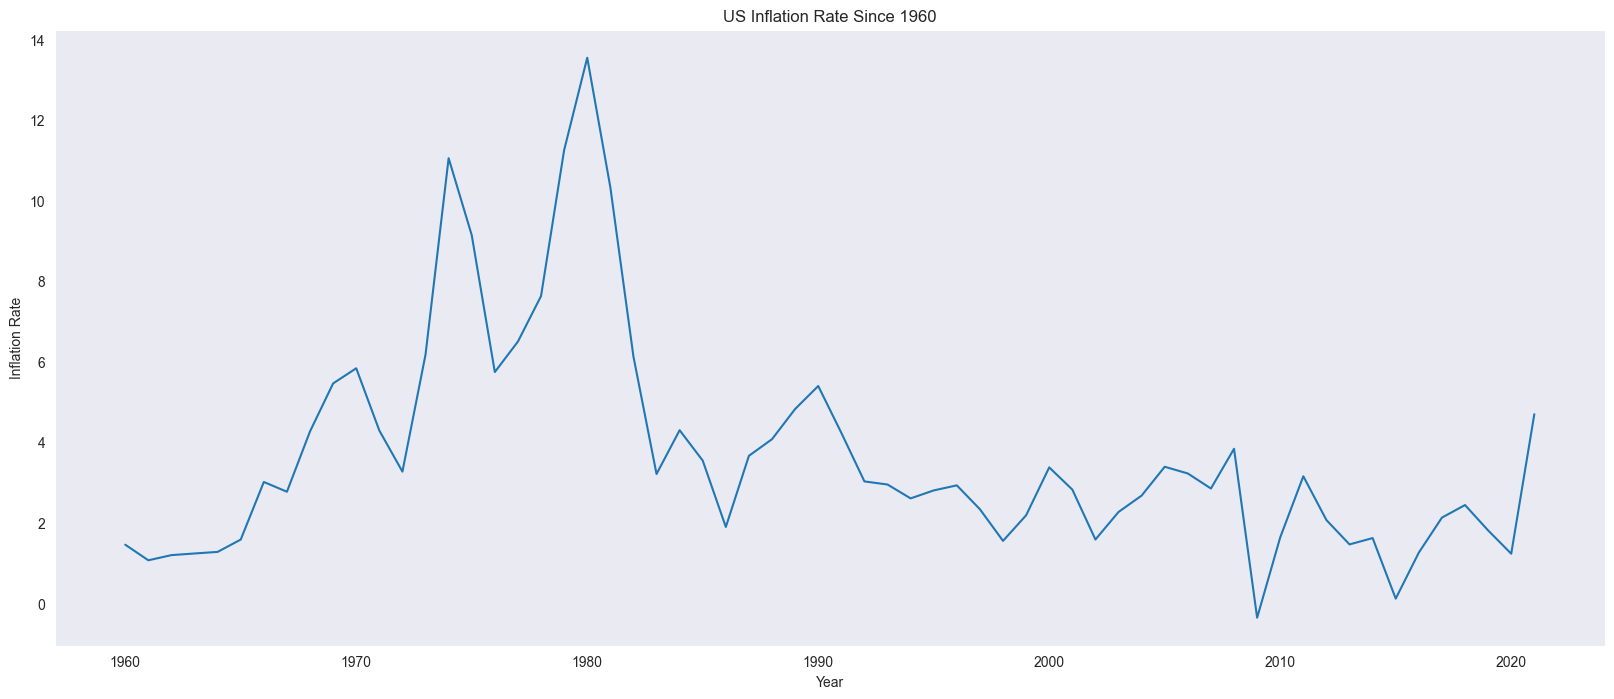

In [15]:
sns.set_style("dark")
plt.figure(figsize=(20,8))
plot = sns.lineplot(x=us_df.index, y=us_df.inflation_rate)
plot.set(title="US Inflation Rate Since 1960", xlabel='Year', ylabel='Inflation Rate')

In [34]:
### Process to make it per year(montly cpi)
cpi_df = pd.read_csv("..\\data\\cpiDataPerMonth.csv", parse_dates=[0])
print("Monthly Data:")
print(cpi_df)
cpi_df['MONTH'] = cpi_df['DATE'].dt.month
cpi_df = cpi_df[cpi_df['MONTH'] == 12]
cpi_df['YEAR'] = cpi_df['DATE'].dt.year
cpi_df = cpi_df.drop(columns=['DATE', 'MONTH'])
cpi_df = cpi_df.reset_index(drop=True)
cpi_df = cpi_df.set_index('YEAR')
cpi_df = cpi_df.rename(columns={
    'USACPIALLMINMEI' : 'CPI'
})
cpi_df.index.rename('Year', inplace=True)
print("\nYearly Data:")
print(cpi_df)

Monthly Data:
          DATE  USACPIALLMINMEI
0   1960-01-01        12.361982
1   1960-02-01        12.404174
2   1960-03-01        12.404174
3   1960-04-01        12.446365
4   1960-05-01        12.446365
..         ...              ...
739 2021-08-01       115.420835
740 2021-09-01       115.734314
741 2021-10-01       116.695849
742 2021-11-01       117.269225
743 2021-12-01       117.629537

[744 rows x 2 columns]

Yearly Data:
             CPI
Year            
1960   12.572938
1961   12.657320
1962   12.826084
1963   13.037040
1964   13.163613
...          ...
2017  104.011105
2018  105.997882
2019  108.420071
2020  109.896758
2021  117.629537

[62 rows x 1 columns]


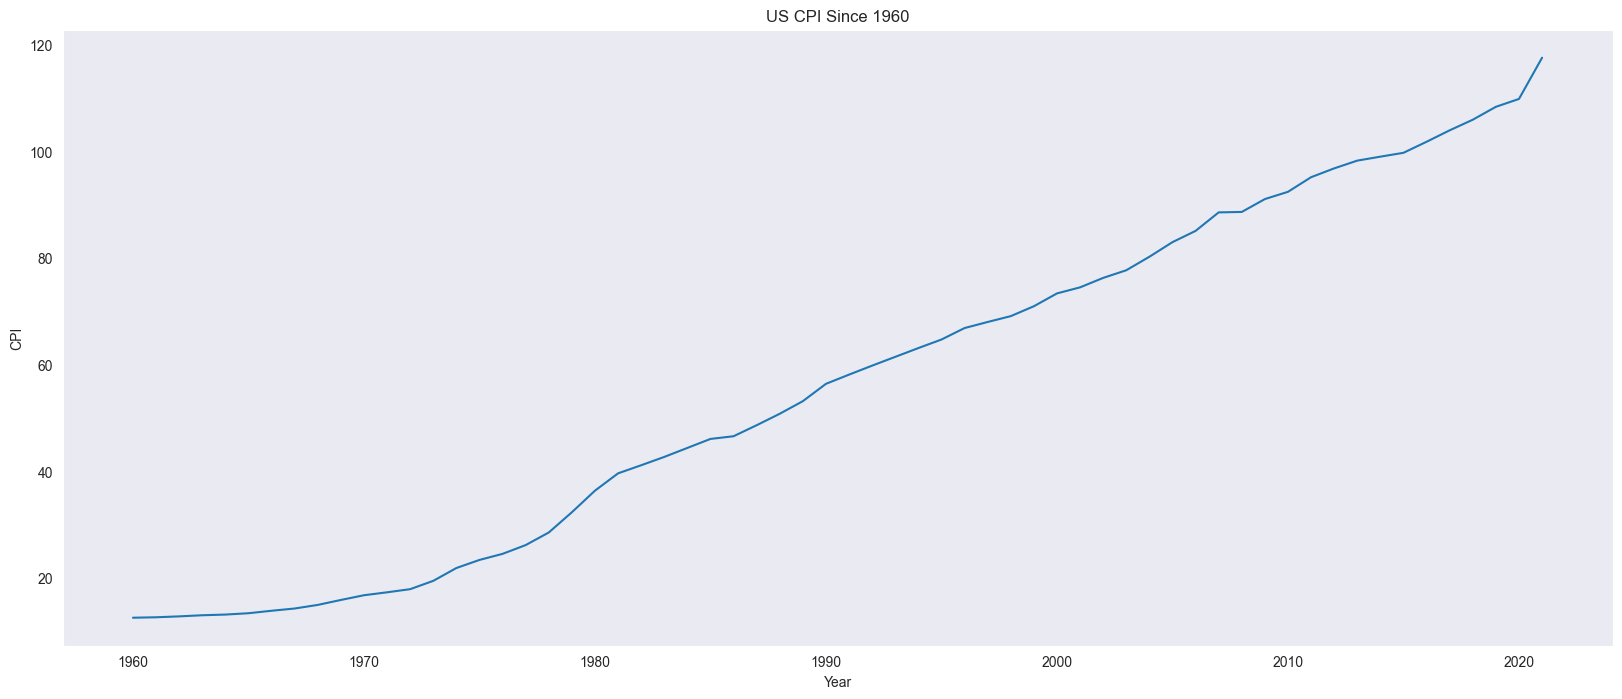

In [9]:
### EDA Plot
sns.set_style("dark")
plt.figure(figsize=(20,8))
plot = sns.lineplot(x=cpi_df.index, y=cpi_df.CPI)
plot.set(title="US CPI Since 1960", xlabel='Year', ylabel='CPI');

In [76]:
from sklearn.preprocessing import OneHotEncoder
### Create the full df
full_df = us_df.join(congress_data).join(cpi_df)
### One Hot encode party stuff
ohe = OneHotEncoder()
ohe_fit = ohe.fit_transform(full_df[['Party', ' Congress Maj Party']])
ohe_fit = pd.DataFrame(ohe_fit.toarray()).rename(columns={
    0: "DemPresParty",
    1: 'RepPresParty',
    2: 'DemCongParty',
    3: 'RepCongParty'
})

ohe_fit = ohe_fit.apply(lambda x: x.astype(int))
ohe_fit['Year'] = list(range(1960, 2022))
ohe_fit.set_index('Year', inplace=True)
sal_df = pd.read_csv('..\\data\\averageSalary.csv', index_col='Year')
### Final Data Preprocessing Step
full_df = full_df.drop(columns=['Name', 'Party', ' Congress Maj Party', 'Congress Min Party']).join(ohe_fit).join(sal_df)
print(full_df)

      inflation_rate  Congress Maj Num  Congress Min Num  Other Num   \
Year                                                                   
1960        1.457976               232               203           0   
1961        1.070724               282               153           1   
1962        1.198773               282               153           1   
1963        1.239669               264               173           0   
1964        1.278912               264               173           0   
...              ...               ...               ...         ...   
2017        2.130110               247               288           0   
2018        2.442583               247               288           0   
2019        1.812210               241               194           0   
2020        1.233584               241               194           0   
2021        4.697859               235               199           0   

      Congress Session  Congress Percent Maj         CPI  DemPr

In [84]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

#'full_df' is the preprocessed dataframe and 'Inflation Rate' is the target variable
X = full_df.drop('inflation_rate', axis=1)
y = full_df['inflation_rate']
X_cpi = full_df.drop('CPI', axis=1)
y_cpi = full_df['CPI']
X_sal = full_df.drop('Average Salary', axis=1)
y_sal = full_df['Average Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_cpi_train, X_cpi_test, y_cpi_train, y_cpi_test = train_test_split(X_cpi, y_cpi, test_size=0.2, random_state=42)
X_sal_train, X_sal_test, y_sal_train, y_sal_test = train_test_split(X_sal, y_sal, test_size=0.2, random_state=42)

# linear regression model
lr = LinearRegression()
lr_cpi = LinearRegression()
lr_sal = LinearRegression()

# Fit the model to the training data
lr.fit(X_train, y_train)
lr_cpi.fit(X_cpi_train, y_cpi_train)
lr_sal.fit(X_sal_train, y_sal_train)

# Make predictions on the testing data
y_pred = lr.predict(X_test)
y_cpi_pred = lr_cpi.predict(X_cpi_test)
y_sal_pred = lr_sal.predict(X_sal_test)

# Evaluate the model
mse = np.mean((y_test - y_pred)**2)
rmse = np.sqrt(mse)
r2 = lr.score(X_test, y_test)

# Random forest regression model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rf_mse = -rf_scores.mean()
rf_r2 = r2_score(y_test, rf.fit(X_train, y_train).predict(X_test))

# Support vector regression model
svr = SVR(kernel='rbf', C=10, gamma=0.1, epsilon=0.1)
svr_scores = cross_val_score(svr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
svr_mse = -svr_scores.mean()
svr_r2 = r2_score(y_test, svr.fit(X_train, y_train).predict(X_test))

print("For Inflation Rate :")
print("\nLinear Regression:")
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)
print('\nRandom Forest Regression:')
print('Mean Squared Error:', rf_mse)
print('R-squared:', rf_r2)
print('\nSupport Vector Regression:')
print('Mean Squared Error:', svr_mse)
print('R-squared:', svr_r2)

mse_cpi = np.mean((y_cpi_test - y_cpi_pred)**2)
rmse_cpi = np.sqrt(mse_cpi)
r2_cpi = lr_cpi.score(X_cpi_test, y_cpi_test)

print("\nFor CPI :")
print('Mean Squared Error:', mse_cpi)
print('Root Mean Squared Error:', rmse_cpi)
print('R-squared:', r2_cpi)

mse_sal = np.mean((y_sal_test - y_sal_pred)**2)
rmse_sal = np.sqrt(mse_sal)
r2_sal = lr_sal.score(X_sal_test, y_sal_test)

print("\nFor Salary :")
print('Mean Squared Error:', mse_sal)
print('Root Mean Squared Error:', rmse_sal)
print('R-squared:', r2_sal)

For Inflation Rate :

Linear Regression:
Mean Squared Error: 2.6833811160858447
Root Mean Squared Error: 1.6381029015558957
R-squared: -0.09743920591354471

Random Forest Regression:
Mean Squared Error: 2.8992266379082627
R-squared: 0.3289612329474715

Support Vector Regression:
Mean Squared Error: 9.340399788121246
R-squared: -0.27122569369538985

For CPI :
Mean Squared Error: 7.240007519958434
Root Mean Squared Error: 2.69072620679965
R-squared: 0.9948624091574636

For Salary :
Mean Squared Error: 2914689.465789924
Root Mean Squared Error: 1707.2461643799127
R-squared: 0.9918824214168536


         Predicted    Actual
Year                        
1960   5347.292163   4007.12
1965   2727.375711   4658.72
1969   4433.384695   5893.76
1972   5307.191626   7133.80
1976   8229.751794   9226.48
1985  18009.712626  16822.51
1990  23271.185079  21027.98
2007  39818.160938  40405.48
2008  39894.206176  41334.97
2010  41479.637686  41673.83
2016  48449.834716  48642.15
2017  50975.247788  50321.89
2019  50033.245090  54099.99


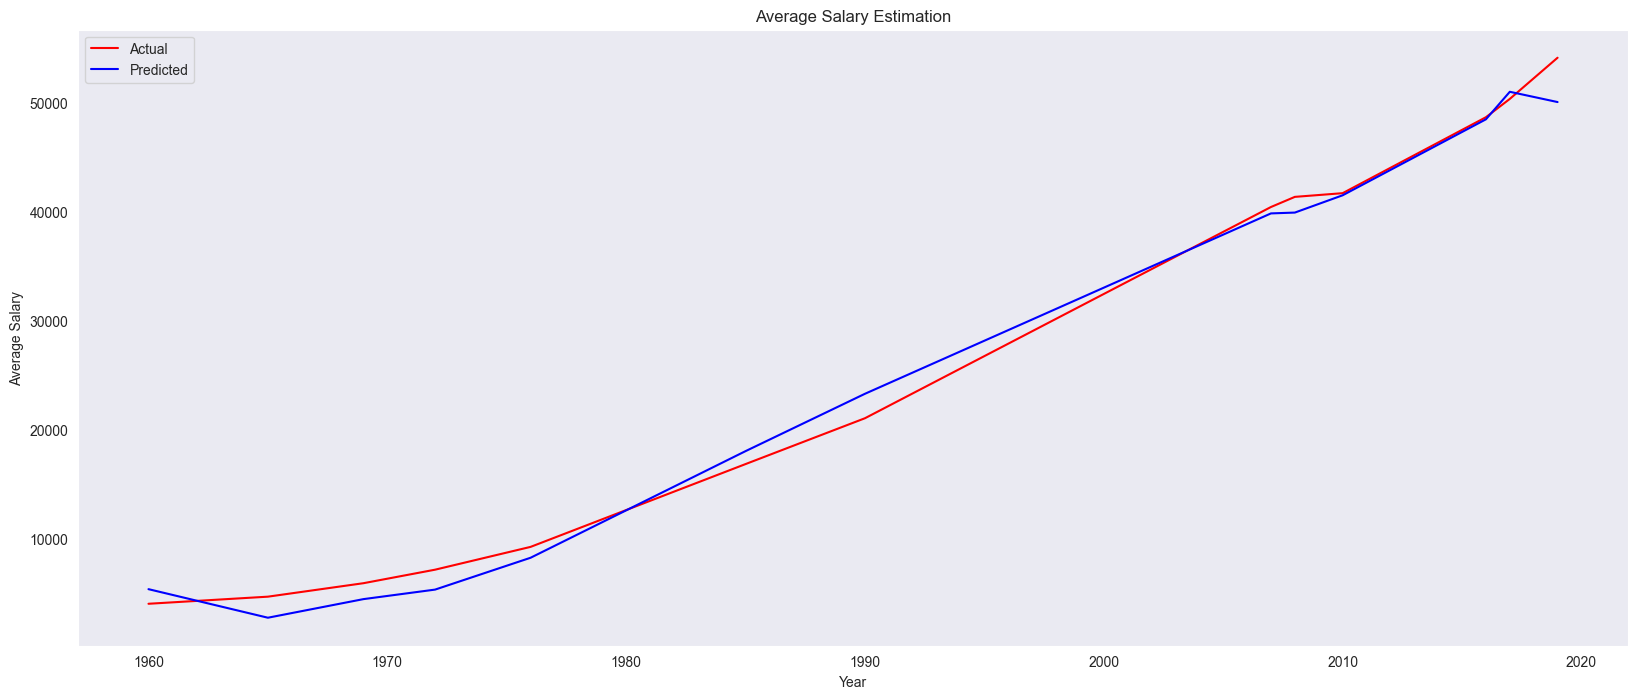

In [95]:
results_sal = pd.DataFrame({'Predicted': y_sal_pred, 'Actual': y_sal_test}).sort_index()
print(results_sal)

sns.set_style("dark")
plt.figure(figsize=(20,8))

plot = sns.lineplot(x=results_sal.index, y=results_sal['Actual'], color='red', label='Actual')
plot = sns.lineplot(x=results_sal.index, y=results_sal['Predicted'], color='blue', label='Predicted')

plot.set(title="Average Salary Estimation", xlabel='Year', ylabel='Average Salary')
plt.show()

       Predicted      Actual
Year                        
1960    5.677114   12.572938
1965   15.479815   13.416759
1969   17.606740   15.906032
1972   21.221055   17.931203
1976   26.720158   24.555201
1985   45.750357   46.114836
1990   53.280180   56.451647
2007   87.348897   88.616428
2008   87.810819   88.697435
2010   91.968155   92.473958
2016  101.671119  101.862736
2017  104.795414  104.011105
2019  111.647682  108.420071


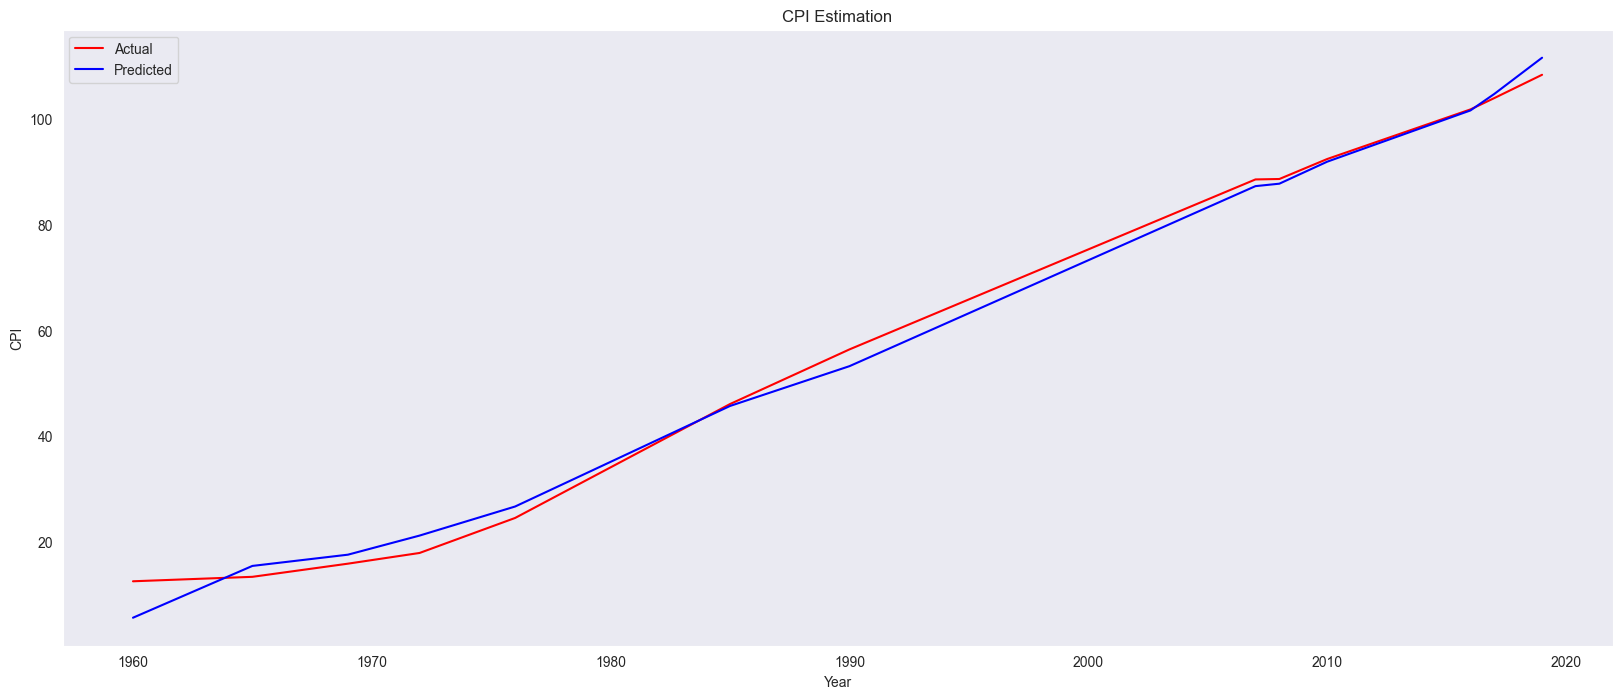

In [96]:
results_cpi = pd.DataFrame({'Predicted': y_cpi_pred, 'Actual': y_cpi_test}).sort_index()
print(results_cpi)

sns.set_style("dark")
plt.figure(figsize=(20,8))

plot = sns.lineplot(x=results_cpi.index, y=results_cpi['Actual'], color='red', label='Actual')
plot = sns.lineplot(x=results_cpi.index, y=results_cpi['Predicted'], color='blue', label='Predicted')

plot.set(title="CPI Estimation", xlabel='Year', ylabel='CPI')
plt.show()

      Predicted    Actual
Year                     
1960  -1.926136  1.457976
1965   3.046472  1.585169
1969   5.317489  5.462386
1972   5.633037  3.272278
1976   5.893722  5.744813
1985   6.046858  3.545644
1990   4.129598  5.397956
2007   1.984421  2.852672
2008   1.994828  3.839100
2010   1.227484  1.640043
2016   1.251095  1.261583
2017   3.314996  2.130110
2019   3.256410  1.812210


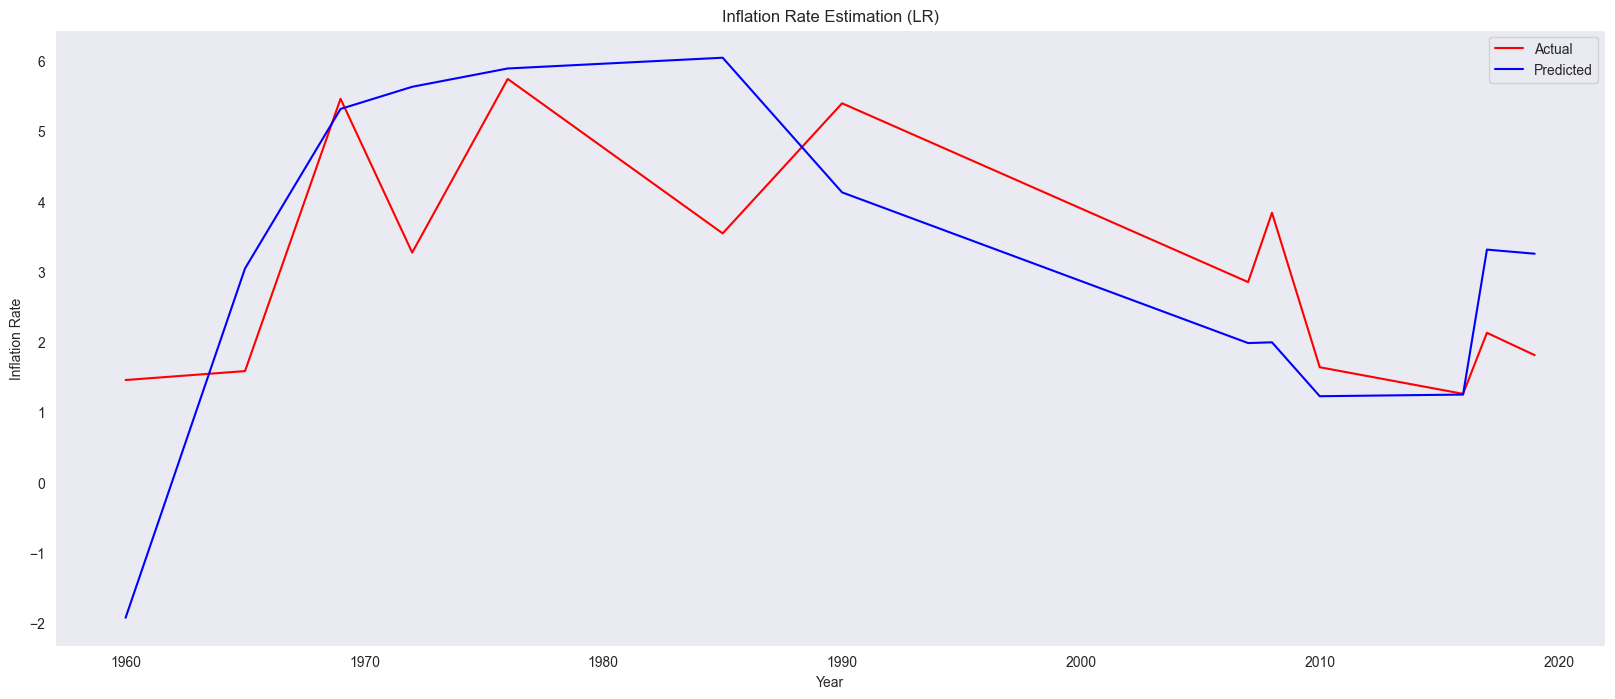

In [97]:
results = pd.DataFrame({'Predicted': y_pred, 'Actual': y_test}).sort_index()
print(results)

sns.set_style("dark")
plt.figure(figsize=(20,8))

plot = sns.lineplot(x=results.index, y=results['Actual'], color='red', label='Actual')
plot = sns.lineplot(x=results.index, y=results['Predicted'], color='blue', label='Predicted')

plot.set(title="Inflation Rate Estimation (LR)", xlabel='Year', ylabel='Inflation Rate')

plt.legend()
plt.show()

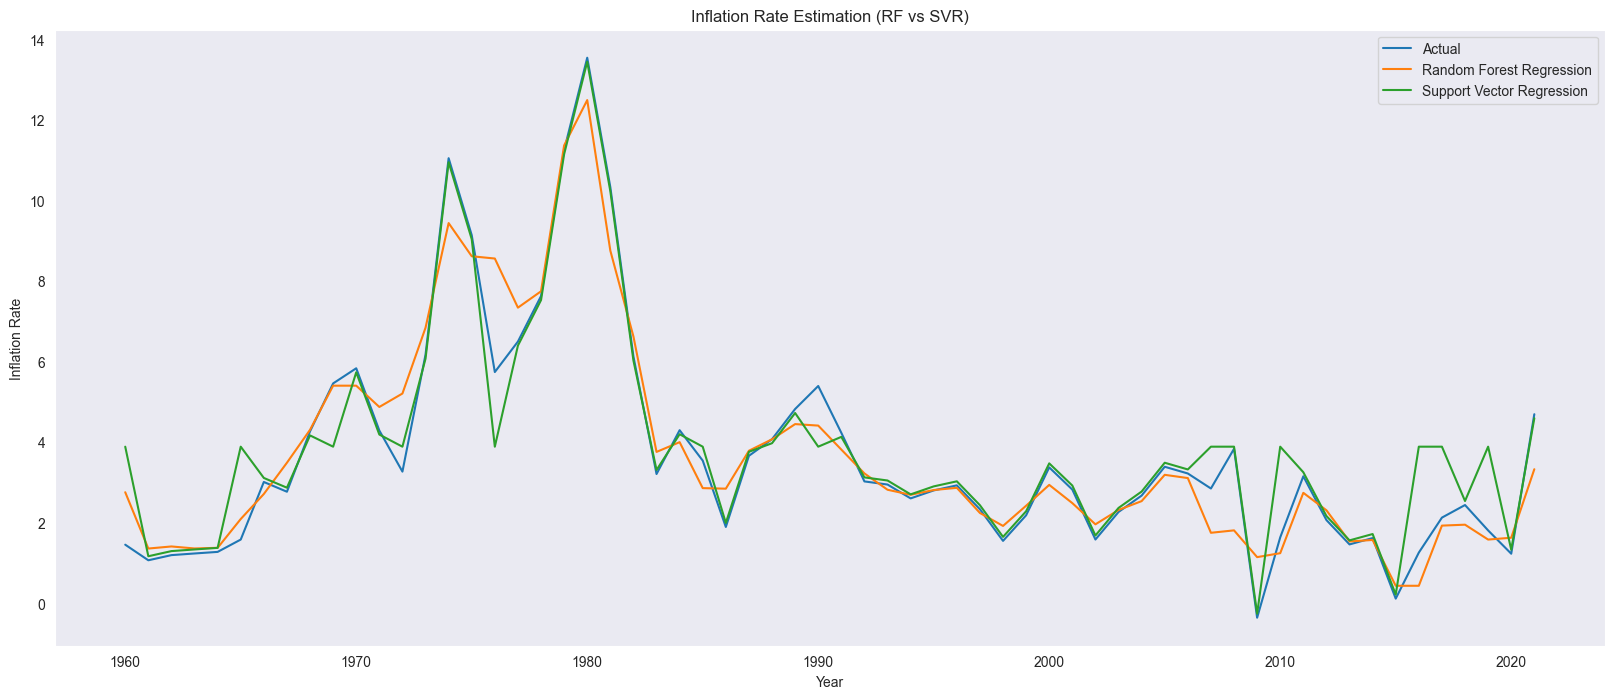

In [92]:
plt.figure(figsize=(20,8))
sns.lineplot(x=full_df.index, y=full_df['inflation_rate'], label='Actual')

sns.lineplot(x=full_df.index, y=rf.predict(full_df.drop('inflation_rate', axis=1)), label='Random Forest Regression')

sns.lineplot(x=full_df.index, y=svr.predict(full_df.drop('inflation_rate', axis=1)), label='Support Vector Regression')

plt.title('Inflation Rate Estimation (RF vs SVR)')
plt.xlabel('Year')
plt.ylabel('Inflation Rate')

plt.legend()
plt.show()